In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import pickle
from pathlib import Path

In [3]:
import lmfit
import matplotlib
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms
import numpy as np
import scipy.optimize
import seaborn as sns
import sounddevice as sd
import uncertainties
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox
from scipy.constants import c, pi
from uncertainties import ufloat, unumpy as unp

In [4]:
import arc
matplotlib.style.use('default')

In [5]:
import skrf as rf

In [6]:
from tqdm import tqdm

In [7]:
from suprtools.fp_theory.geometry import SymmetricCavityGeometry
# from suprtools.fp_theory.coupling import CouplingConfig
# from suprtools.fp_theory.modes import ScalarModeBasis
from suprtools.plotting import sslab_style, label_subplots
from suprtools.rf import WideScanData, fit_mode, test_a_fit, RingdownSet, CWMeasurement, FabryPerotModeParams, ModeMaskingPolicy

In [8]:
mirror_test_dir = Path('../data')
caecilia_data_dir = mirror_test_dir / 'Caecilia'
cassia_data_dir = mirror_test_dir / 'Cassia'
domitia_data_dir = mirror_test_dir / 'Domitia'
egnatia_data_dir = mirror_test_dir / 'Egnatia'
flaminia_data_dir = mirror_test_dir / 'Flaminia'

In [9]:
stage_sweep_data_dir = flaminia_data_dir / '20240530-stage-sweep-data'

In [10]:
flaminia_fsr = 3.2941326e+9

In [11]:
modelist = list(itertools.product(range(20, 35), (+1, -1)))

## Load thrus

In [12]:
thrus_dir = '20240607-thru-calibration'
cal_dirnames = {
    0.75: '20240608-thru0p75k-withVarattenSwitchAmp',
    0.88: '20240608-thru0p88k-withVarattenSwitchAmp',
    1.02: '20240609-thru1p02k-withVarattenSwitchAmp',
    1.025: '20240609-thru1p02k-withVarattenSwitchAmp-bis',
    1.10: '20240608-thru1p10k-withVarattenSwitchAmp',
    1.264: '20240608-thru1p264k-withVarattenSwitchAmp',
    4.47: '20240608-thru4p47k-withVarattenSwitchAmp',
    4.59: '20240608-thru4p59k-withVarattenSwitchAmp',
    4.7: '20240608-thru4p7k-withVarattenSwitchAmp',
    300: '20240607-roomTthru-withVarattenSwitchAmp',
}

In [13]:
thru_cals = {
    key: WideScanData.from_windows(flaminia_data_dir / thrus_dir / dirname, network_name=f'{key} K')
    for key, dirname in cal_dirnames.items()
}
# reference planes located per our fridge-top cal: port 1 of switch and distal end of H-bend on VNAX 2

thru_cals_raw = {
    key: WideScanData.from_windows(flaminia_data_dir / thrus_dir / dirname, network_name=f'{key} K raw', raw=True)
    for key, dirname in cal_dirnames.items()
}

100%|██████████| 1/1 [00:00<00:00, 151.90it/s]


In [14]:
ns = rf.NetworkSet([data.s21 for temp, data in thru_cals.items() if temp < 100])

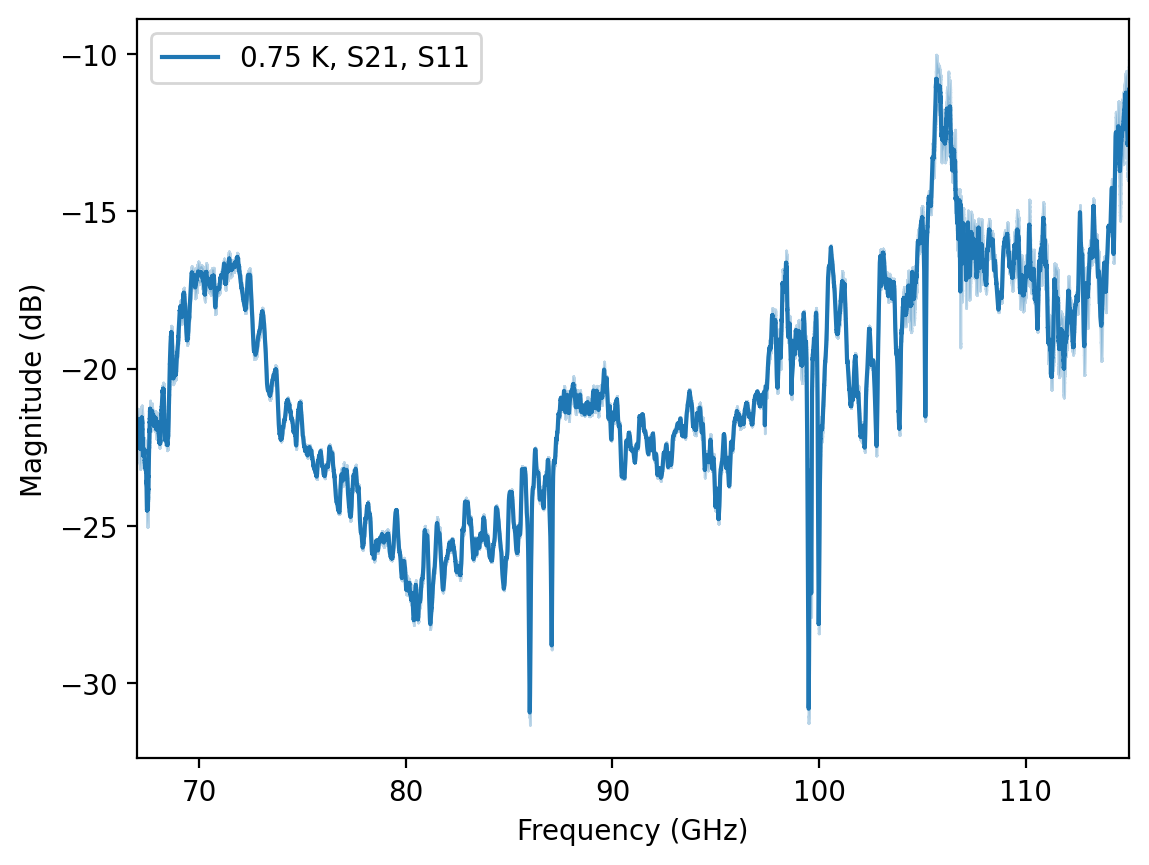

In [15]:
ns.plot_uncertainty_bounds_s_db()

In [16]:
palette = sns.cubehelix_palette(
    n_colors=len(thru_cals)-1, rot=0, start=0, dark=0.25, reverse=True)
palette

[[0.2398055600768935, 0.22900294668204535, 0.3993369846059208],
 [0.31243948413687045, 0.2998234739254133, 0.4987508892887351],
 [0.38573344000000004, 0.37194208, 0.5894022400000001],
 [0.4596874276662822, 0.44535876490580545, 0.6712910367397155],
 [0.534301447135717, 0.5200735286428297, 0.7444172795078816],
 [0.6135555740099962, 0.6001230049980777, 0.8119258008458285],
 [0.6895243956016917, 0.6775022463360245, 0.8670657486197616],
 [0.7661532489965398, 0.7561795665051904, 0.9134431424221453],
 [0.8434421341945405, 0.8361549655055748, 0.9510579822529797]]

Text(35.347222222222214, 0.5, 'Thru $|S_{21}|$ [dB]')

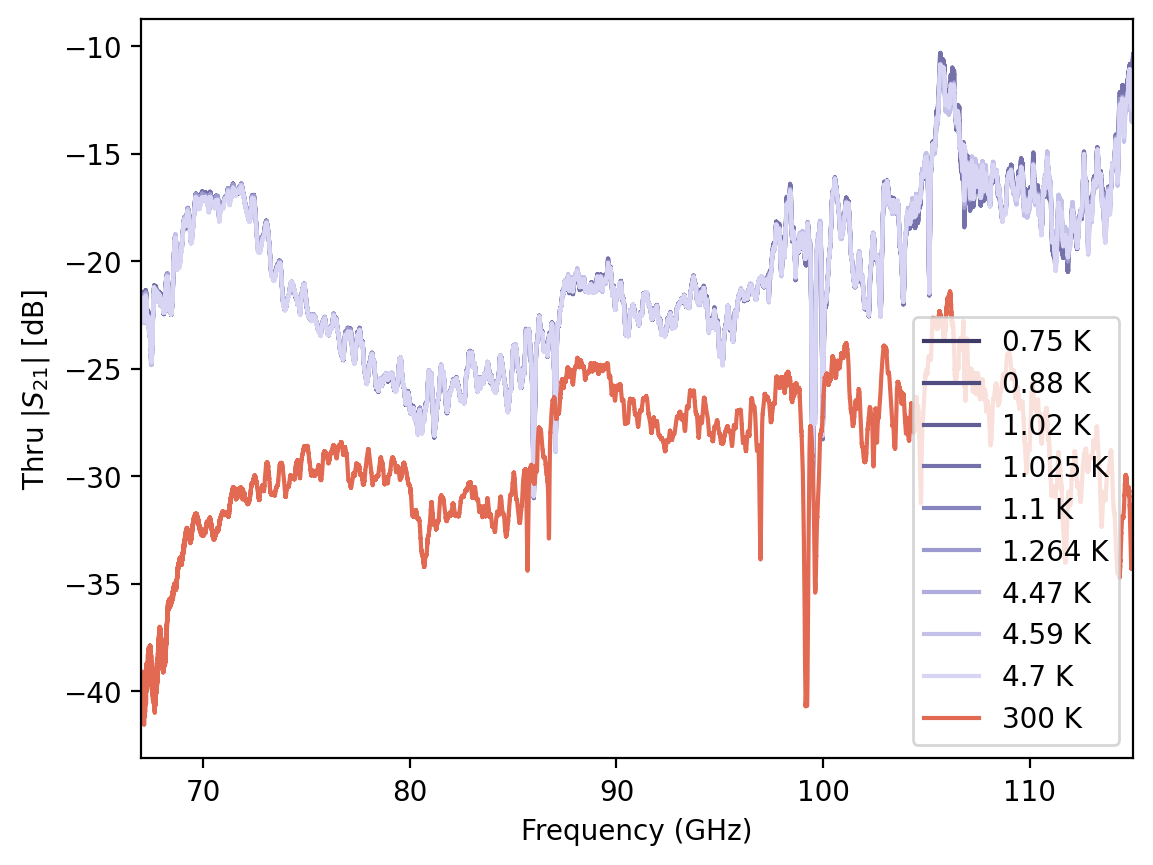

In [17]:
fig, ax = plt.subplots()
for i, temp in enumerate(thru_cals):
    color = palette[i] if i < len(palette) else sns.color_palette('coolwarm')[-1]
    thru_cals[temp].s21.plot_s_db(ax=ax, color=color, label=f'{temp} K')
    # thru_cals_raw[temp].s21.plot_s_db(ax=ax, alpha=0.5, color=color)
# ax.set_xlim(90e+9, 90.01e+9)
# ax.set_ylim(-21.6, -21.4)

ax.set_ylabel('Thru $|S_{21}|$ [dB]')

Text(30.972222222222214, 0.5, '$S_{21}$ ratio [dB]')

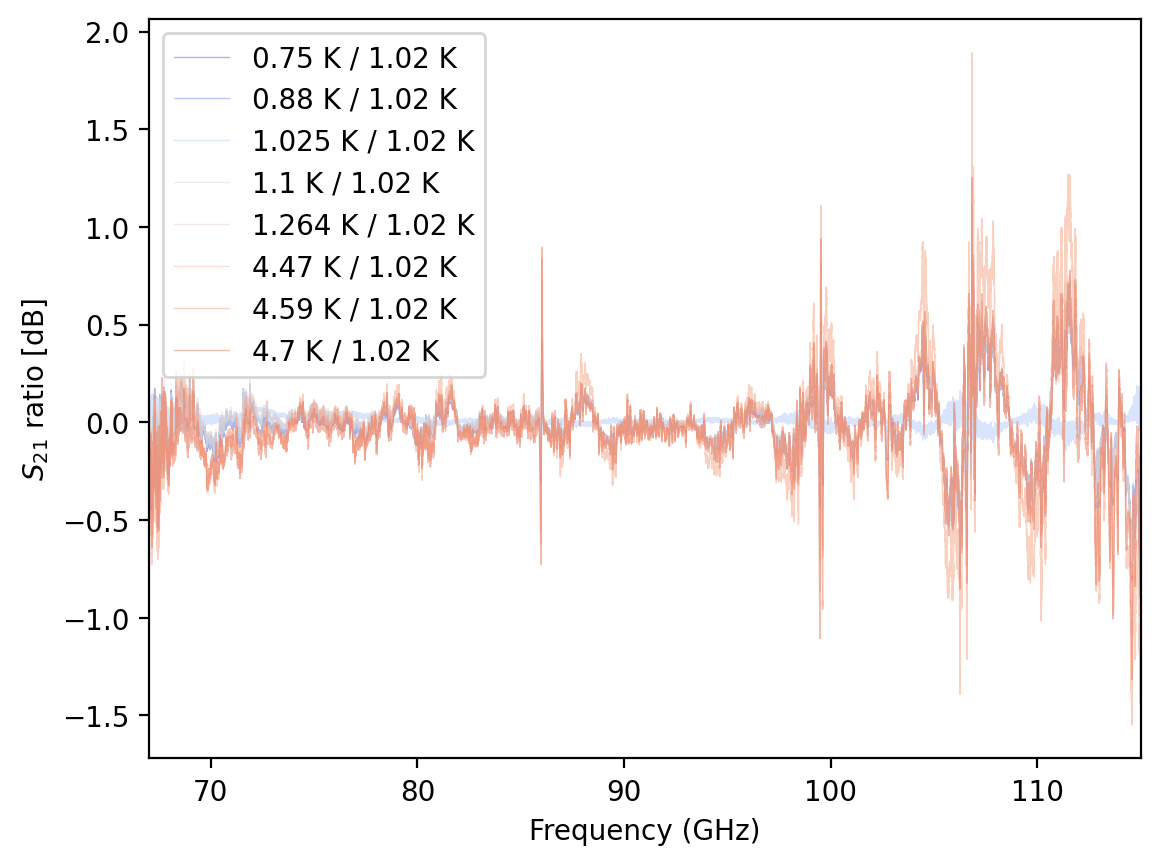

In [18]:
fig, ax = plt.subplots()

palette = sns.color_palette('coolwarm', n_colors=len(thru_cals))

fiducial_temp = 1.02

for i, temp in enumerate(thru_cals):
    if temp in [fiducial_temp, 300] or temp > 5:
        continue
    color = palette[i]
    divided_network = thru_cals[temp].s21 / thru_cals[fiducial_temp].s21
    divided_network.plot_s_db(ax=ax, color=color, label=f'{temp} K / {fiducial_temp} K', alpha=0.5, linewidth=0.5)
    # thru_cals_raw[temp].s21.plot_s_db(ax=ax, alpha=0.5, color=color)
# ax.set_xlim(90e+9, 90.01e+9)
# ax.set_ylim(-21.6, -21.4)

ax.set_ylabel('$S_{21}$ ratio [dB]')

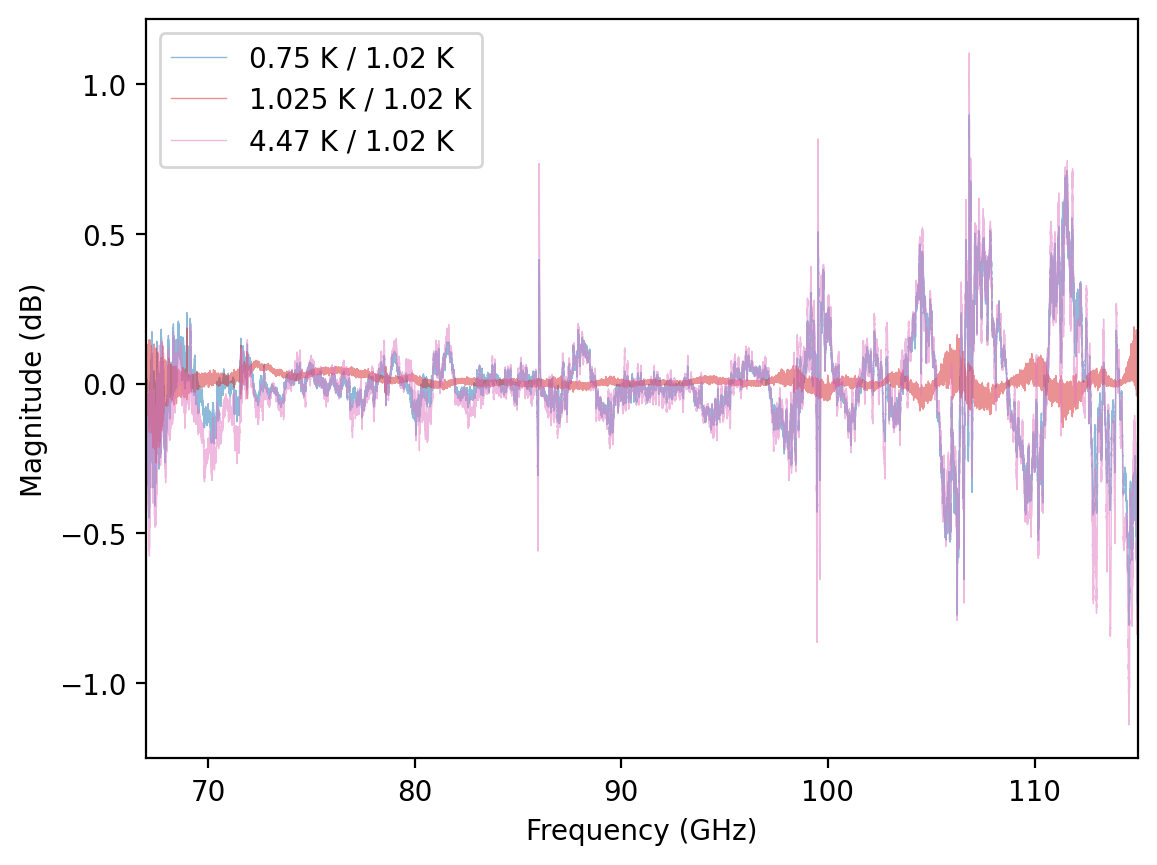

In [19]:
fig, ax = plt.subplots()

# palette = sns.color_palette('coolwarm', n_colors=len(thru_cals))
# palette
palette = sns.color_palette()
for i, temp in enumerate(thru_cals):
    if temp not in [0.75, 1.025, 4.47]:#, 0.88, 1.02, 1.025, 1.1]:
        continue
    color = palette[i]
    divided_network = thru_cals[temp].s21 / thru_cals[1.02].s21
    divided_network.plot_s_db(ax=ax, color=color, label=f'{temp} K / 1.02 K', alpha=0.5, linewidth=0.5)
    # thru_cals_raw[temp].s21.plot_s_db(ax=ax, alpha=0.5, color=color)
# ax.set_xlim(90e+9, 90.01e+9)
# ax.set_ylim(-21.6, -21.4)

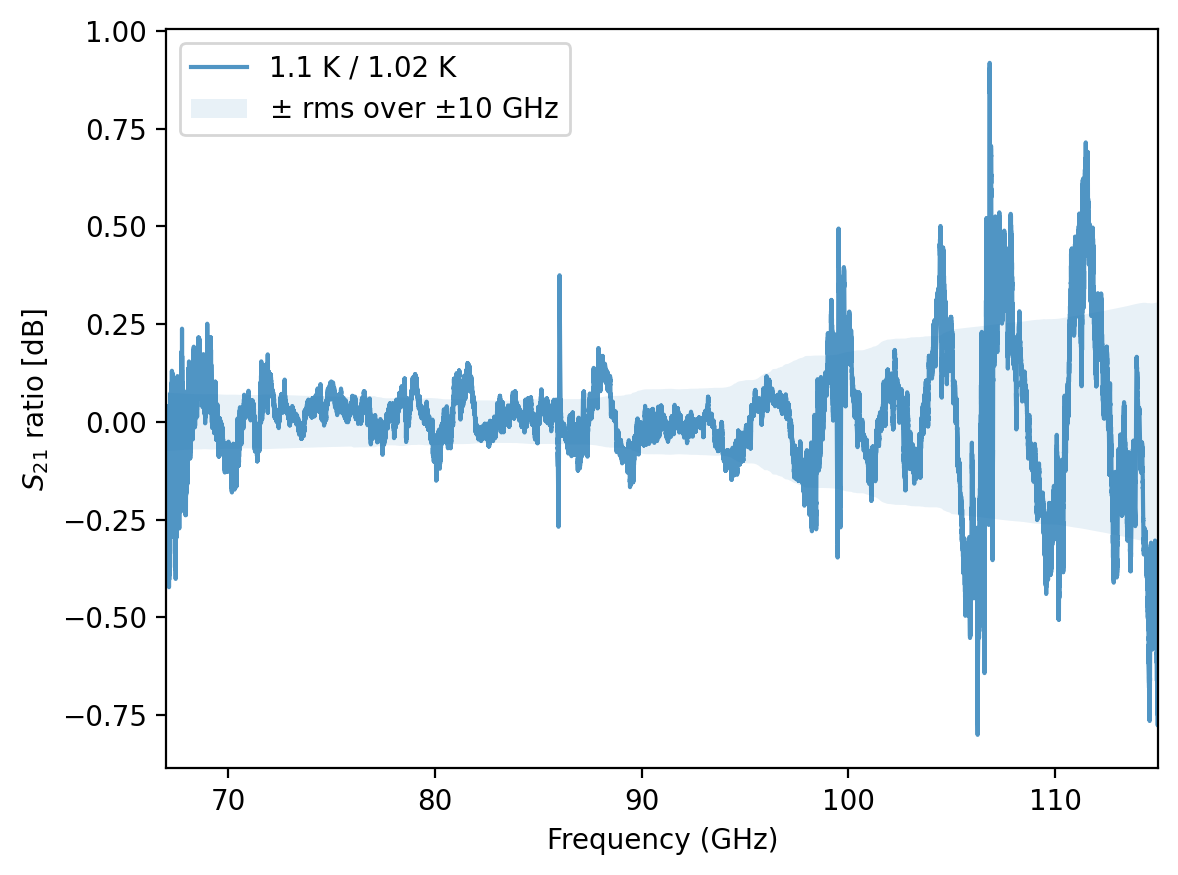

In [20]:
fig, ax = plt.subplots()

divided_network = thru_cals[1.1].s21 / thru_cals[1.02].s21
divided_network.plot_s_db(ax=ax, alpha=0.78, label='1.1 K / 1.02 K')
freqobj = divided_network.frequency

freqs = 1e+9 * np.linspace(67, 115, num=961)
ax.set_ylabel('$S_{21}$ ratio [dB]')

for halfspan in [10e+9]:
    windows = (
        rf.Frequency(
            max(freqobj.start, freq - halfspan),
            min(freqobj.stop, freq + halfspan),
            npoints=(1 + int(2 * halfspan / 500e+3)),
            unit='Hz',
        )
        for freq in freqs
    )

    stds = np.array([
        np.sqrt(np.mean(rf.complex_2_db(divided_network[window].s)**2))
        for window in windows
    ])

    ax.fill_between(
        freqs,
        -stds,
        +stds,
        label=fr'$\pm$ rms over $\pm {halfspan/1e+9:.0f}$ GHz',
        alpha=0.1,
    )
    ax.legend()

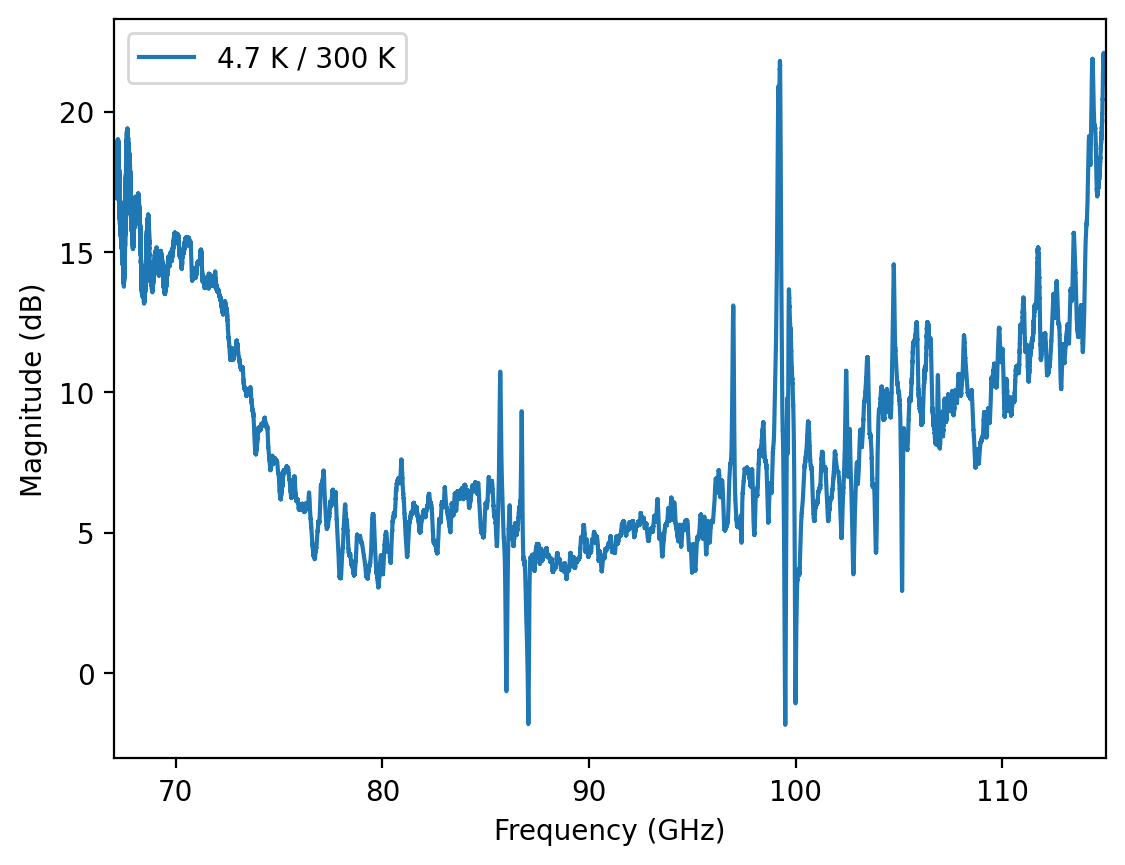

In [21]:
divided_network = thru_cals[4.7].s21 / thru_cals[300].s21
divided_network.plot_s_db(label='4.7 K / 300 K')

In [22]:
shift_est_net = thru_cals[1.02].s21

In [23]:
uncertainty_est_net = thru_cals[1.1].s21 / thru_cals[1.02].s21
def line_atten_db_uncertainty_single(freq, halfspan=10e+9):
    freqobj = uncertainty_est_net.frequency
    window = rf.Frequency(
        max(freqobj.start, freq - halfspan),
        min(freqobj.stop, freq + halfspan),
        npoints=(1 + int(2 * halfspan / 500e+3)),
        unit='Hz',
    )
    return np.sqrt(np.mean(rf.complex_2_db(uncertainty_est_net[window].s)**2))

line_atten_db_uncertainty = np.vectorize(line_atten_db_uncertainty_single)

In [24]:
def line_atten_db_single(freq):
    return ufloat(
        rf.complex_2_db(shift_est_net.interpolate([freq], coords='polar').s.item()),
        line_atten_db_uncertainty(freq),
    )
    # return ufloat(
    #     rf.complex_2_db(shift_est_net.interpolate([freq], coords='polar').s.item()),
    #     db_uncertainty(freq),
    # )

line_atten_db = np.vectorize(line_atten_db_single)

In [25]:
line_atten_db(83e+9)

array(-24.246774866121758+/-0.05414896923758443, dtype=object)

### Theory coax attenuation (from datasheet)

In [26]:
def theory_coax_attenuation_db(freq, length_ft):
    freq_mhz = freq / 1e+6
    z0 = ufloat(50, 2.5)
    center_diam_in = ufloat(0.0113, 0.0005)
    dielec_diam_in = 0.037
    dielec_pow_fctr = 0.0002
    dielec_const = 2.02
    atten_db_per_100ft = 0.434 * np.sqrt(freq_mhz) / z0 * (1 / center_diam_in + 1/dielec_diam_in) + 2.78 * freq_mhz * np.sqrt(dielec_const) * dielec_pow_fctr
    return atten_db_per_100ft * length_ft / 100

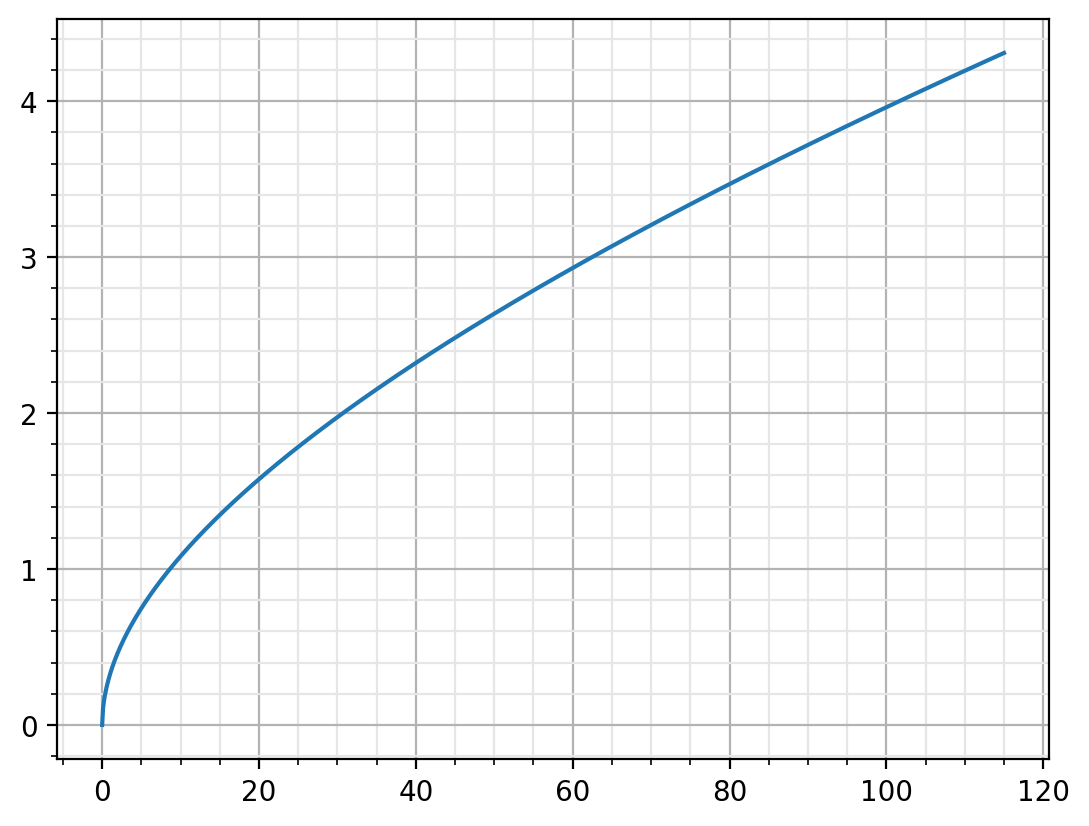

In [27]:
fig, ax = plt.subplots()

freqs = np.linspace(0, 115, num=1000) * 1e+9
atten_db = theory_coax_attenuation_db(freqs, length_ft=1) #length_ft=ufloat(6, 1)/12)
ax.plot(
    freqs / 1e+9,
    unp.nominal_values(atten_db),
)

sslab_style(ax)

Doesn't agree with values on datasheet or on test report?

### Test report insertion loss extrapolation

In [28]:
def data_coax_atten_db(freq, length_in):
    # scaling by sqrt(freq)
    # return 2 * np.sqrt(freq / (65e+9 / 2)) * (length_in / 8)
    
    # linear scaling: 1 dB/(4 divs on datasheet = 0.4 * 65 GHz)
    span = 65e+9
    return - (2 + (freq - 0.5*span) / (0.4*span)) * (length_in / 8)

In [29]:
print(line_atten_db(70e+9))

-16.88+/-0.07


In [30]:
print(data_coax_atten_db(70e+9, ufloat(6.5, 0.5)))

-2.80+/-0.22


In [31]:
def total_insertion_loss_db(freq):
    return line_atten_db(freq) + data_coax_atten_db(freq, length_in=ufloat(6.5, 0.5))

In [32]:
print(total_insertion_loss_db(70e+9))

-19.68+/-0.23


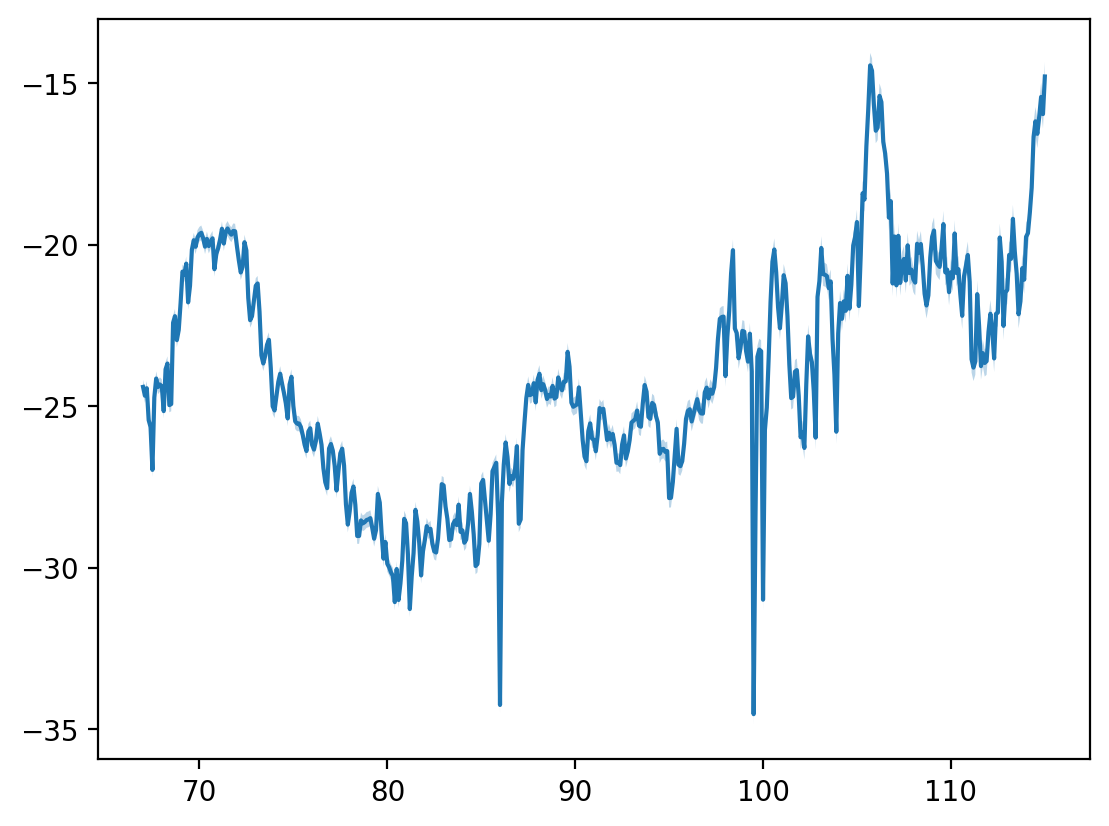

In [33]:
fig, ax = plt.subplots()

freqs_ghz = np.linspace(67, 115, num=(48*10+1))
insertion_loss_db = total_insertion_loss_db(freqs_ghz * 1e+9)
ax.plot(
    freqs_ghz,
    unp.nominal_values(insertion_loss_db),
)
ax.fill_between(
    freqs_ghz,
    unp.nominal_values(insertion_loss_db) - unp.std_devs(insertion_loss_db),
    unp.nominal_values(insertion_loss_db) + unp.std_devs(insertion_loss_db),
    alpha=0.3,
)

## Load sweeps

In [34]:
def load_sweeps_with_adjustments(mainpath, exceptiondict=dict(), lacks_23=False):
    default_windows = {
        mode_tuple: (
            stage_sweep_data_dir
            / mainpath
            / f'window{i - (2 if (lacks_23 and mode_tuple[0] > 23) else 0):03d}.h5'
        )
        for i, mode_tuple in enumerate(modelist)
        if not (lacks_23 and mode_tuple[0] == 23)
    }
    
    windows = default_windows | exceptiondict
    return {
        mode_tuple: None if path is None else WideScanData.from_window(path, network_name=str(mode_tuple))
        for mode_tuple, path in tqdm(windows.items())
    }

In [35]:
stage4p5_sweeps = load_sweeps_with_adjustments(
    '20240530-tem20-34-00xy-sweep-turboptoff-stage4p500mm',
    {
        (28, -1): stage_sweep_data_dir / '20240531-tem28-00y-sweep-turboptoff-stage4p500mm/window000.h5',
        (31, +1): stage_sweep_data_dir / '20240531-tem31-00x-sweep-turboptoff-stage4p500mm/window000.h5',
    },
    lacks_23=True,
)

stage4p0_sweeps = load_sweeps_with_adjustments(
    '20240531-tem20-34-00xy-sweep-turboptoff-stage4p000mm',
    {
        (21, -1): stage_sweep_data_dir / '20240531-tem21-00y-sweep-turboptoff-stage4p000mm/window000.h5'
    },
    lacks_23=True,
)

stage3p5_sweeps = load_sweeps_with_adjustments(
    '20240531-tem20-34-00xy-sweep-turboptoff-stage3p500mm',
    {
        (22, -1): stage_sweep_data_dir / '20240531-tem22-00y-sweep-turboptoff-stage3p500mm/window000.h5',
    },
    lacks_23=True,
)

stage2p00_sweeps = load_sweeps_with_adjustments(
    '20240603-tem20-34-00xy-sweep-turboptoff-stage2p000mm',
    {
        (32, +1): None,
        (32, -1): None,
    },
    lacks_23=False,
)

100%|██████████| 30/30 [00:00<00:00, 194.49it/s]


In [36]:
all_sweeps = {
    -3.75: load_sweeps_with_adjustments('20240605-tem20-34-00xy-sweep-turboptoff-stagen3p750mm'),
    -3.00: load_sweeps_with_adjustments('20240605-tem20-34-00xy-sweep-turboptoff-stagen3p000mm'),
    -2.25: load_sweeps_with_adjustments('20240605-tem20-34-00xy-sweep-turboptoff-stagen2p250mm'),
    -1.50: load_sweeps_with_adjustments('20240605-tem20-34-00xy-sweep-turboptoff-stagen1p500mm'),
    -0.75: load_sweeps_with_adjustments('20240605-tem20-34-00xy-sweep-turboptoff-stagen0p750mm'),
    0.00: load_sweeps_with_adjustments('20240605-tem20-34-00xy-sweep-turboptoff-stage0p000mm'),
    0.50: load_sweeps_with_adjustments('20240604-tem20-34-00xy-sweep-turboptoff-stage0p500mm'),
    1.00: load_sweeps_with_adjustments('20240604-tem20-34-00xy-sweep-turboptoff-stage1p000mm'),
    1.25: load_sweeps_with_adjustments('20240604-tem20-34-00xy-sweep-turboptoff-stage1p250mm'),
    1.50: load_sweeps_with_adjustments('20240604-tem20-34-00xy-sweep-turboptoff-stage1p500mm'),
    1.75: load_sweeps_with_adjustments('20240603-tem20-34-00xy-sweep-turboptoff-stage1p750mm'),
    2.00: stage2p00_sweeps,
    2.50: load_sweeps_with_adjustments('20240603-tem20-34-00xy-sweep-turboptoff-stage2p500mm'),
    2.75: load_sweeps_with_adjustments('20240603-tem20-34-00xy-sweep-turboptoff-stage2p750mm'),
    3.25: load_sweeps_with_adjustments('20240603-tem20-34-00xy-sweep-turboptoff-stage3p250mm'),
    3.5: stage3p5_sweeps,
    4.0: stage4p0_sweeps,
    4.5: stage4p5_sweeps,
}
stage_positions_sweeps = list(all_sweeps)

100%|██████████| 30/30 [00:00<00:00, 181.39it/s]


Variation in thru cal across our scans is negligible:

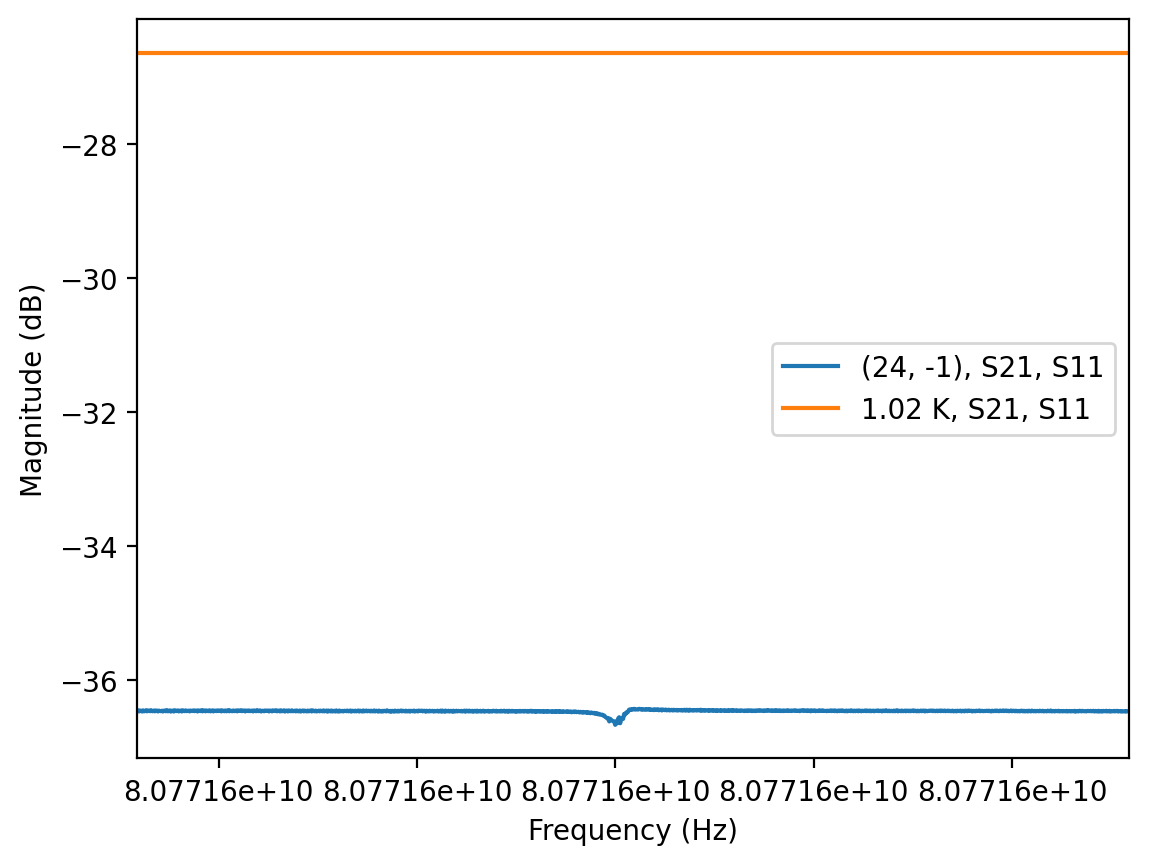

In [37]:
sweep = all_sweeps[0.5][24, -1].s21
sweep.plot_s_db()
shift_est_net.interpolate(sweep.frequency, coords='polar').plot_s_db()

In [38]:
records_dict = {
    stage_pos: [
        [
            (
                pos_sweeps[(mode_q, pol)].s21.fit_narrow_mode(2)
                if pos_sweeps.get((mode_q, pol)) is not None
                else (ufloat(np.nan, np.nan),) * 4
            )
            for pol in (+1, -1)
        ]
        for mode_q in tqdm(range(20, 35))
    ]
    for stage_pos, pos_sweeps in all_sweeps.items()
}

  0%|          | 0/15 [00:00<?, ?it/s]/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 3.0770588899239052e+16).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
  7%|▋         | 1/15 [00:00<00:05,  2.52it/s]/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 1.5895696737166925e+17).
  vf.vector_fit(n_poles_real=0, n_poles_cmp

In [39]:
# stagepos, mode, pol

records = [records_dict[pos] for pos in stage_positions_sweeps]

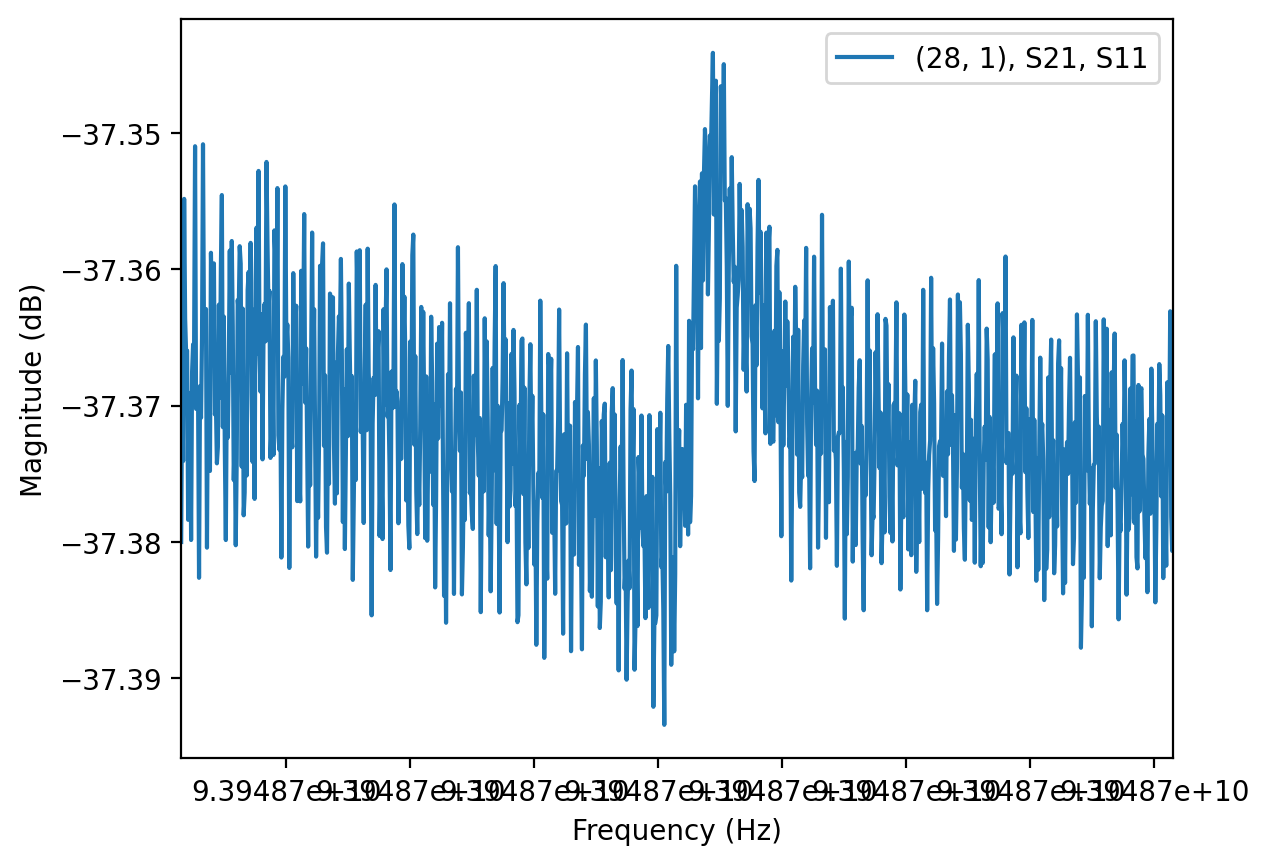

In [40]:
all_sweeps[0][28, +1].s21.plot_s_db()

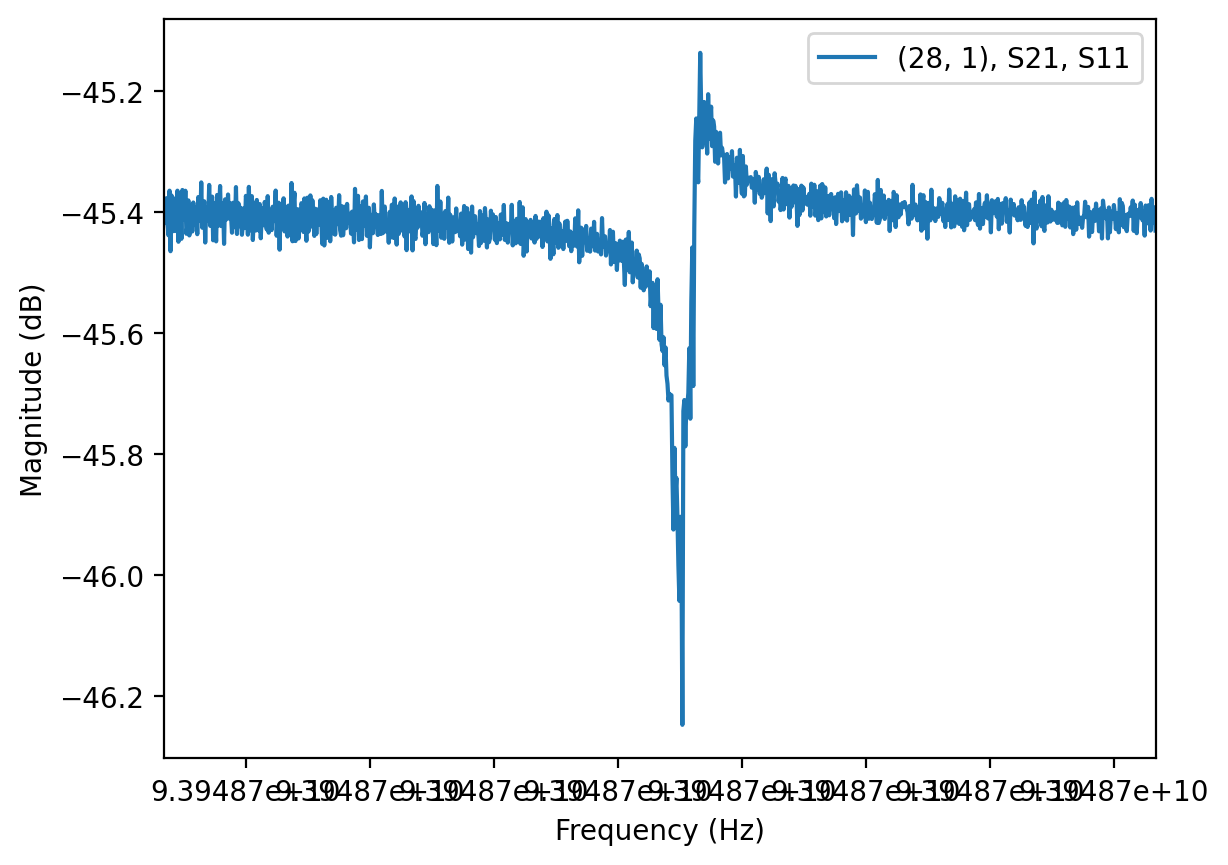

In [41]:
all_sweeps[0.5][28, +1].s21.plot_s_db()

In [42]:
all_sweeps.keys()

dict_keys([-3.75, -3.0, -2.25, -1.5, -0.75, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 2.75, 3.25, 3.5, 4.0, 4.5])

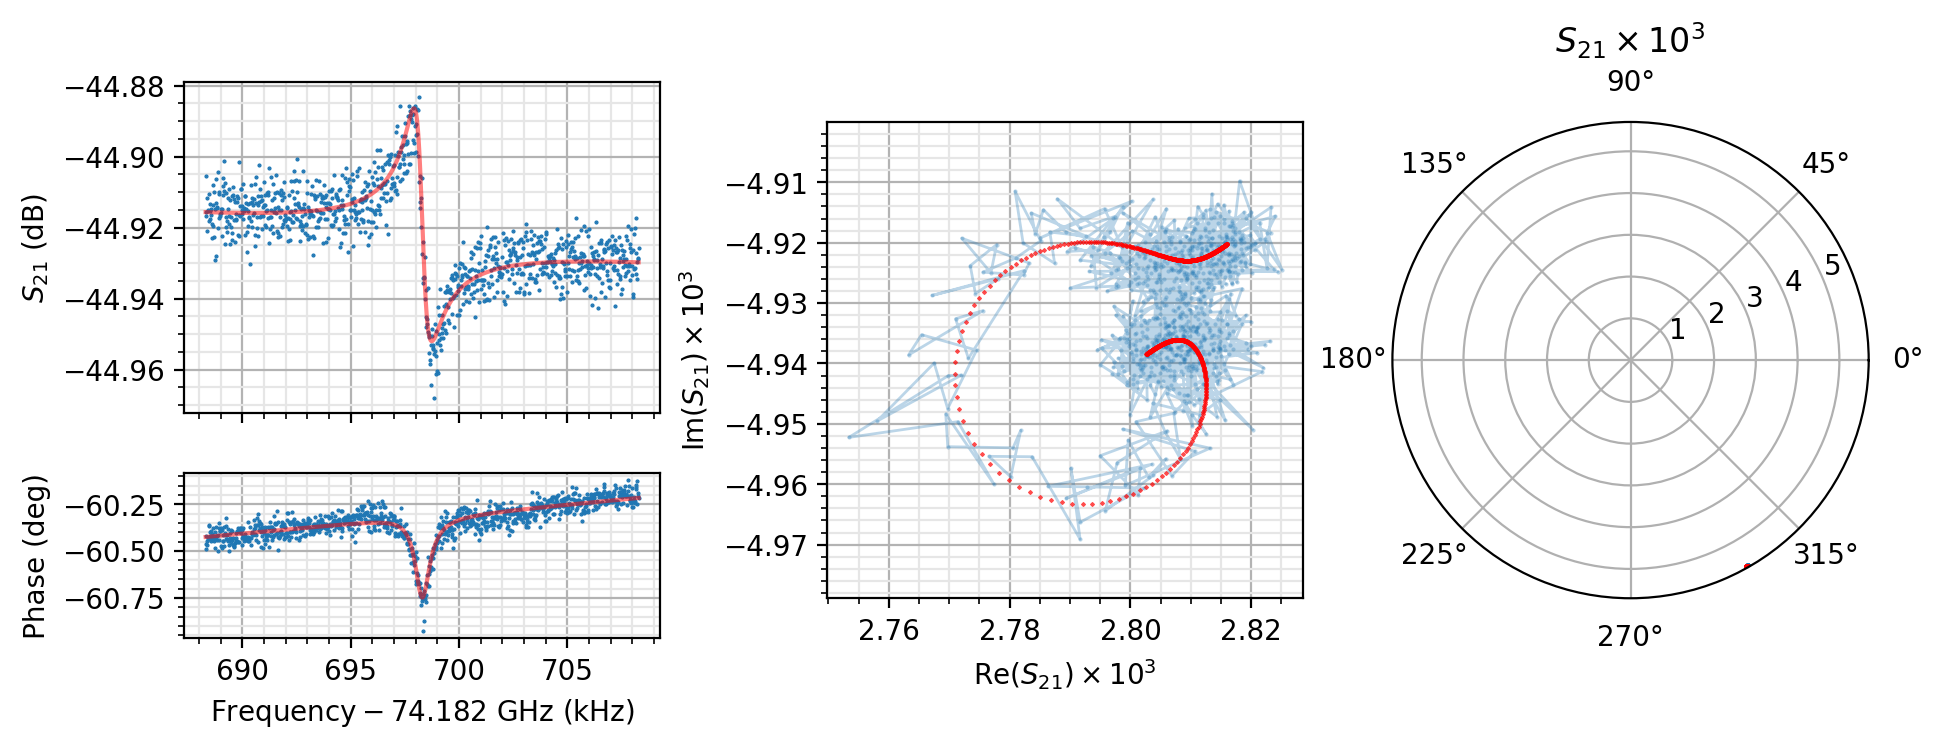

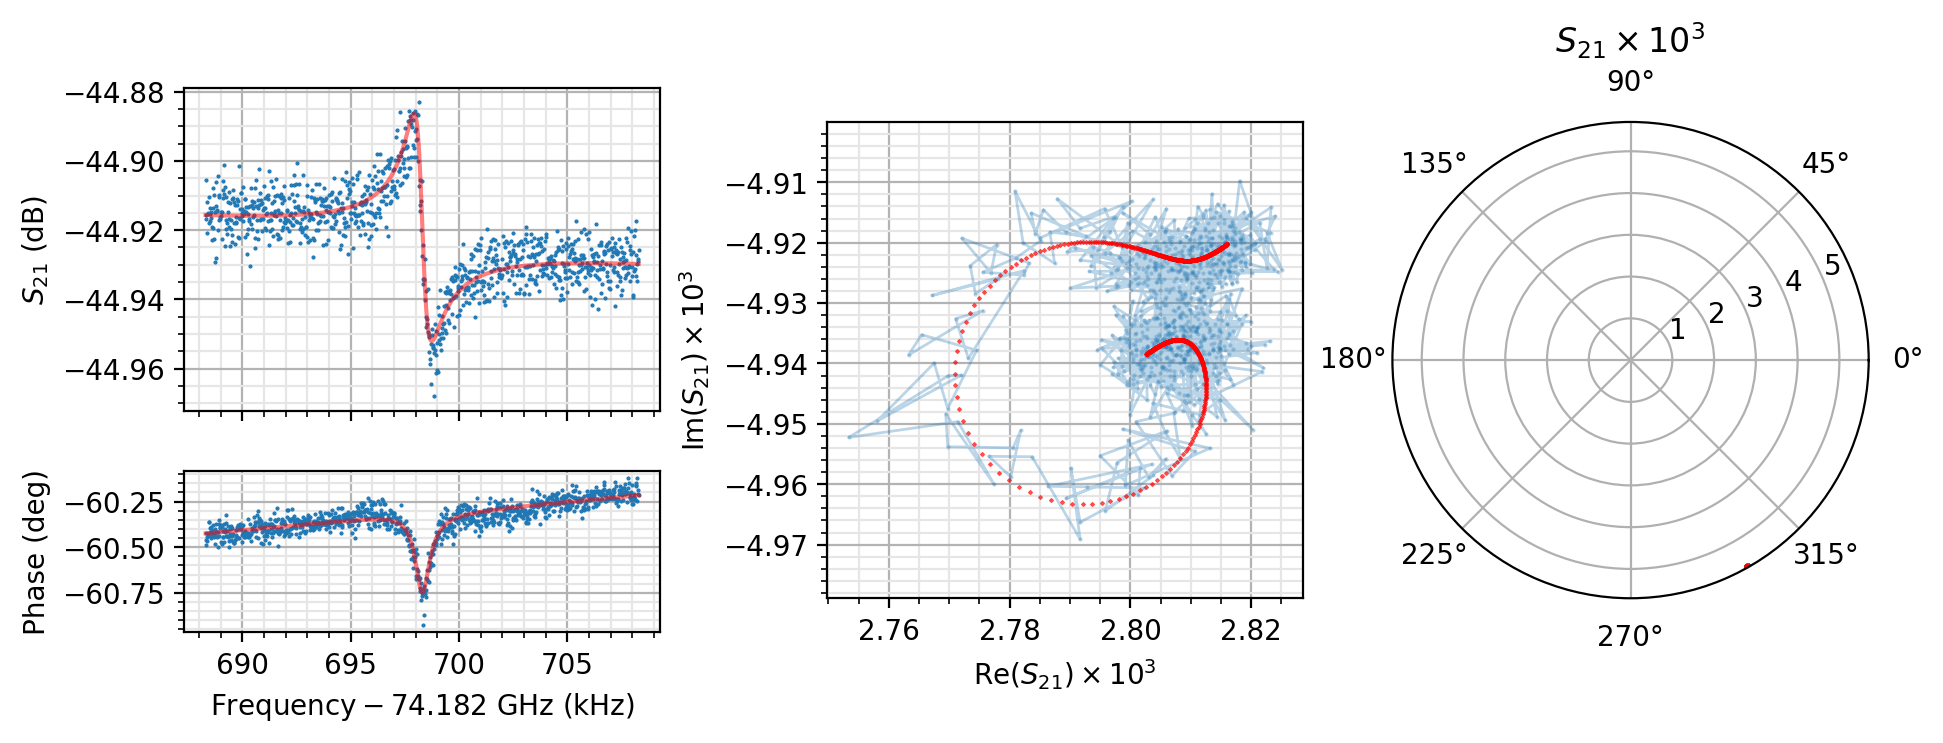

In [43]:
vf = all_sweeps[-3.75][22, -1].s21.fit_network(n_poles_cmplx=2)
vf.visualize()

In [44]:
with open('flaminia-sweep-fit-params.pickle', 'wb') as fp:
    pickle.dump(records, fp)

In [45]:
with open('flaminia-sweep-fit-params.pickle', 'rb') as fp:
    records = pickle.load(fp)